In [216]:
import pandas as pd
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
import re
from nltk.corpus import stopwords
import nltk
from nltk.stem import PorterStemmer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import load_model

df_train = pd.read_pickle(r'\Data\train.pkl')
df_val = pd.read_pickle(r'\Data\validation.pkl')
df_test = pd.read_pickle(r'\Data\test.pkl')

In [217]:
print(df_train['text'])

0                                  i didnt feel humiliated
1        i can go from feeling so hopeless to so damned...
2         im grabbing a minute to post i feel greedy wrong
3        i am ever feeling nostalgic about the fireplac...
4                                     i am feeling grouchy
                               ...                        
15995    i just had a very brief time in the beanbag an...
15996    i am now turning and i feel pathetic that i am...
15997                       i feel strong and good overall
15998    i feel like this was such a rude comment and i...
15999    i know a lot but i feel so stupid because i ca...
Name: text, Length: 16000, dtype: object


In [218]:
# Sammenlign kolonnerne og find fælles værdier
fælles_værdier_train_val = set(df_train['text']).intersection(set(df_val['text']))
print(len(fælles_værdier_train_val))
if fælles_værdier_train_val:
    print("Der er fælles værdier:", fælles_værdier_train_val)
else:
    print("Ingen fælles værdier.")

0
Ingen fælles værdier.


In [219]:
# Sammenlign kolonnerne og find fælles værdier
fælles_værdier_val_test = set(df_val['text']).intersection(set(df_test['text']))
print(len(fælles_værdier_val_test))
if fælles_værdier_val_test:
    print("Der er fælles værdier:", fælles_værdier_val_test)
else:
    print("Ingen fælles værdier.")

0
Ingen fælles værdier.


Clean the text

In [220]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def clean_text(text):
    text = text.lower()                                         # Convert to lowercase
    text = re.sub(r'\d+', '', text)                             # Remove numbers
    text = re.sub(r'[^\w\s]', '', text)                         # Remove punctuation
    text = re.sub(r'\s+', ' ', text).strip()                    # Remove extra whitespace
    words = text.split()
    words = [word for word in words if word not in stop_words]  # Remove stopwords
    tokens = [stemmer.stem(word) for word in words if word not in stop_words] # Perform stemming
    return " ".join(tokens)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\klykk\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [221]:
df_train['text_clean'] = df_train['text'].apply(lambda x: clean_text(x))
df_val['text_clean'] = df_val['text'].apply(lambda x: clean_text(x))
df_test['text_clean'] = df_test['text'].apply(lambda x: clean_text(x))


In [222]:
# Initialize tokenizer and fit on training data
tokenizer = Tokenizer(num_words=15214, oov_token="<OOV>", filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(df_train['text'].to_list())

print(tokenizer.word_index)

train_sequences = tokenizer.texts_to_sequences(df_train['text_clean'].to_list())
val_sequences = tokenizer.texts_to_sequences(df_val['text_clean'].to_list())
test_sequences = tokenizer.texts_to_sequences(df_test['text_clean'].to_list())

print("Train sequences before padding:", train_sequences)


# Constructing Vocabulary and Index-Word Mapping
word2idx = tokenizer.word_index  # Ord til indeks
vocab_size = len(word2idx) + 1  # +1 for at tage højde for padding-token
print("Vocabulary Size:", vocab_size)


# Pad sequences to ensure uniform length
max_sequence_length = max(len(seq) for seq in train_sequences)
print("Max length:", max_sequence_length)

train_padded = pad_sequences(train_sequences, maxlen=max_sequence_length, padding='post', truncating='post')
val_padded = pad_sequences(val_sequences, maxlen=max_sequence_length, padding='post', truncating='post')
test_padded = pad_sequences(test_sequences, maxlen=max_sequence_length, padding='post', truncating='post')
print("Padded Train Sequences:", train_padded)


# Tjek længde på padded sequences
sequence_lengths = [len(seq) for seq in train_padded]
print(set(sequence_lengths))  # Skal kun indeholde én værdi, f.eks. {100}


# One-hot encoding for categorical targets
train_labels = np.array(df_train['label'])
val_labels = np.array(df_val['label'])
test_labels = np.array(df_test['label'])

y_train_cat = to_categorical(train_labels, num_classes=6) 
y_val_cat = to_categorical(val_labels, num_classes=6) 
y_test_cat = to_categorical(test_labels, num_classes=6)

print("One-hot encoded labels:", y_train_cat, y_val_cat, y_test_cat)


# Divide the data in batches
train_buffer = len(train_padded)
val_buffer = len(val_padded)
test_buffer = len(test_padded)
batch_size = 16
train_batch = train_buffer // batch_size
val_batch = val_buffer // batch_size
test_batch = test_buffer // batch_size


dataset_train = tf.data.Dataset.from_tensor_slices((train_padded,
                                                    y_train_cat)).shuffle(train_buffer)
dataset_train = dataset_train.batch(batch_size, drop_remainder=True)

dataset_val = tf.data.Dataset.from_tensor_slices((val_padded, 
                                                  y_val_cat)).shuffle(val_buffer)
dataset_val = dataset_val.batch(batch_size, drop_remainder=True)

dataset_test = tf.data.Dataset.from_tensor_slices((test_padded, 
                                                    y_test_cat)).shuffle(test_buffer)
dataset_test = dataset_test.batch(batch_size, drop_remainder=True)



{'<OOV>': 1, 'i': 2, 'feel': 3, 'and': 4, 'to': 5, 'the': 6, 'a': 7, 'feeling': 8, 'that': 9, 'of': 10, 'my': 11, 'in': 12, 'it': 13, 'like': 14, 'so': 15, 'for': 16, 'im': 17, 'me': 18, 'but': 19, 'was': 20, 'have': 21, 'is': 22, 'this': 23, 'am': 24, 'with': 25, 'not': 26, 'about': 27, 'be': 28, 'as': 29, 'on': 30, 'you': 31, 'just': 32, 'at': 33, 'when': 34, 'or': 35, 'all': 36, 'because': 37, 'more': 38, 'do': 39, 'can': 40, 'really': 41, 'up': 42, 't': 43, 'are': 44, 'by': 45, 'very': 46, 'know': 47, 'been': 48, 'if': 49, 'out': 50, 'myself': 51, 'time': 52, 'how': 53, 'what': 54, 'get': 55, 'little': 56, 'had': 57, 'now': 58, 'will': 59, 'from': 60, 'being': 61, 'they': 62, 'people': 63, 'them': 64, 'would': 65, 'he': 66, 'want': 67, 'her': 68, 'some': 69, 'think': 70, 'one': 71, 'still': 72, 'ive': 73, 'him': 74, 'even': 75, 'who': 76, 'an': 77, 'life': 78, 'its': 79, 'make': 80, 'there': 81, 'we': 82, 'bit': 83, 'something': 84, 'love': 85, 'much': 86, 'going': 87, 'dont': 88, 

In [223]:
print(dataset_train)
print(dataset_val)
print(dataset_test)

<_BatchDataset element_spec=(TensorSpec(shape=(16, 35), dtype=tf.int32, name=None), TensorSpec(shape=(16, 6), dtype=tf.float64, name=None))>
<_BatchDataset element_spec=(TensorSpec(shape=(16, 35), dtype=tf.int32, name=None), TensorSpec(shape=(16, 6), dtype=tf.float64, name=None))>
<_BatchDataset element_spec=(TensorSpec(shape=(16, 35), dtype=tf.int32, name=None), TensorSpec(shape=(16, 6), dtype=tf.float64, name=None))>


In [224]:
# Bidirectional layer
forward_layer1 = tf.keras.layers.LSTM(64,
                        recurrent_dropout = 0.5,
                        return_sequences=True, 
                        return_state=False, 
                        recurrent_activation='sigmoid', 
                        name = "LSTM1")

backward_layer1 = tf.keras.layers.LSTM(64,
                        recurrent_dropout = 0.5,
                        return_sequences=True, 
                        return_state=False, 
                        recurrent_activation='sigmoid',
                        name = "LSTM2",
                        go_backwards=True)

forward_layer2 = tf.keras.layers.LSTM(64,
                        recurrent_dropout = 0.5,
                        return_sequences=False, 
                        return_state=False, 
                        recurrent_activation='sigmoid', 
                        name = "LSTM3")

backward_layer2 = tf.keras.layers.LSTM(64,
                        recurrent_dropout = 0.5,
                        return_sequences=False, 
                        return_state=False, 
                        recurrent_activation='sigmoid', 
                        go_backwards=True,
                        name = "LSTM4")


model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(max_sequence_length,), name="Input"),
    
    tf.keras.layers.Embedding(input_dim=vocab_size, 
                              output_dim=100,
                              input_length=train_padded.shape[1],
                              name = "Embedding"),

    tf.keras.layers.Bidirectional(layer = forward_layer1, backward_layer = backward_layer1, merge_mode = 'concat', name = 'GRU_bi1'),

    tf.keras.layers.Bidirectional(layer = forward_layer2, backward_layer = backward_layer2, merge_mode = 'concat', name = 'GRU_bi2'),

    tf.keras.layers.Dense(32, activation='relu', name = "Dense3"),

    tf.keras.layers.Dense(6, activation='softmax', name = "DenseLast")
])

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)


model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Hvad der skal overvåges (f.eks. 'val_loss' eller 'val_accuracy')
    patience=5,          # Antal epochs uden forbedring før stop
    restore_best_weights=True,  # Gendan vægtene fra den bedste epoch
    verbose=1            # Print en besked, når træningen stopper
)

model.summary()

c:\Users\klykk\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_42"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Embedding (Embedding)           │ (None, 35, 100)        │     1,521,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ GRU_bi1 (Bidirectional)         │ (None, 35, 128)        │        84,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ GRU_bi2 (Bidirectional)         │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense3 (Dense)                  │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ DenseLast (Dense)               │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,709,022 (6.52 MB)

 Trainable params: 1,709,022 (6.52 MB)

 Non-trainable params: 0 (0.00 B)

In [225]:
history = model.fit(dataset_train, validation_data = dataset_val,
                                            epochs = 50,
                                            callbacks=[early_stopping, lr_scheduler],
                                            verbose = 1
                                            )

Epoch 1/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 88s 82ms/step - accuracy: 0.3315 - loss: 1.5903 - precision: 0.3033 - recall: 0.0145 - val_accuracy: 0.4637 - val_loss: 1.3791 - val_precision: 0.6701 - val_recall: 0.2631 - learning_rate: 5.0000e-04
Epoch 2/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 94s 94ms/step - accuracy: 0.5478 - loss: 1.2072 - precision: 0.7666 - recall: 0.3545 - val_accuracy: 0.5958 - val_loss: 1.1012 - val_precision: 0.7771 - val_recall: 0.4446 - learning_rate: 5.0000e-04
Epoch 3/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 66s 66ms/step - accuracy: 0.6624 - loss: 0.9376 - precision: 0.8122 - recall: 0.5306 - val_accuracy: 0.6038 - val_loss: 1.0619 - val_precision: 0.7789 - val_recall: 0.4582 - learning_rate: 5.0000e-04
Epoch 4/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.7060 - loss: 0.8186 - precision: 0.8447 - recall: 0.5886 - val_accuracy: 0.5938 - val_loss: 1.0813 - val_precision: 0.7399 - val_recall: 0.4819 - learning_rate: 5.0000e-04
Epoch 5/50
1000/1000 ━━━━━━━━━━━

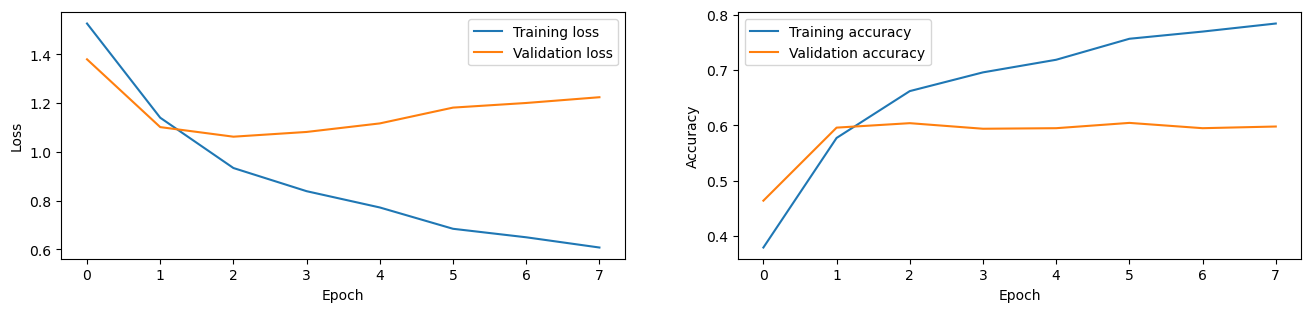

In [226]:
import matplotlib.pyplot as plt
# Plot the accuracy and loss history
fig = plt.figure(figsize=plt.figaspect(0.2))

ax = fig.add_subplot(1, 2, 1)
ax.plot(history.history['loss'], label='Training loss')
ax.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

ax = fig.add_subplot(1, 2, 2)
ax.plot(history.history['accuracy'], label='Training accuracy')
ax.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
model = load_model("RNN_final.h5")

train_accuracy = history.history['accuracy'][2]
train_loss = history.history['loss'][2]
train_precision = history.history['precision'][2]
train_recall = history.history['recall'][2]

print(f"Training Loss: {train_loss}, Validation Accuracy: {train_accuracy}, Train Precision: {train_precision}, Train Recall: {train_recall} ")

val_accuracy = history.history['val_accuracy'][2]
val_loss = history.history['val_loss'][2]
val_precision = history.history['val_precision'][2]
val_recall = history.history['val_precision'][2]


print(f"Val Loss: {val_loss}, Val Accuracy: {val_accuracy}, Val Precision: {val_precision}, Val Recall: {val_recall} ")

test_loss, test_accuracy, test_precision, test_recall = model.evaluate(dataset_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}, Test Precision: {test_precision}, Test Recall: {test_recall}")


Training Loss: 0.9333760738372803, Validation Accuracy: 0.6618124842643738, Train Precision: 0.8128778338432312, Train Recall: 0.5294374823570251 
Val Loss: 1.061864972114563, Val Accuracy: 0.6038306355476379, Val Precision: 0.7789202928543091, Val Recall: 0.7789202928543091 
124/124 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.6172 - loss: 1.0198 - precision: 0.7813 - recall: 0.4798
Test Loss: 1.0419981479644775, Test Accuracy: 0.5957661271095276, Test Precision: 0.7759472727775574, Test Recall: 0.47479838132858276


In [228]:
# Evaluate the model on the test data
epoch_stop = 2 #3-1, index starter ved 0
accuracy = history.history['accuracy']
loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

#loss, accuracy = rnn.evaluate(val_padded, val_targets)
print(f"Accuracy: {accuracy[epoch_stop] * 100:.2f}%")
print(f"Loss: {loss[epoch_stop] * 100:.2f}%")
print(f"Validation Accuracy: {val_acc[epoch_stop] * 100:.2f}%")
print(f"Validation Loss: {val_loss[epoch_stop] * 100:.2f}%")

#name = f'RNN{round(val_acc[epoch_stop],2)}-{round(val_loss[epoch_stop],2)}'
model.save('RNN_final.h5')
!jupyter nbconvert --to script --output {name} RNN.ipynb


Accuracy: 66.18%
Loss: 93.34%
Validation Accuracy: 60.38%
Validation Loss: 106.19%


[NbConvertApp] Converting notebook RNN.ipynb to script
[NbConvertApp] Writing 10276 bytes to RNN0.6-1.06.py
